# Demonstration on 6x6 images

In [1]:
import numpy as np

print(np.random.choice(2, size=(4,)))

[1 0 0 1]


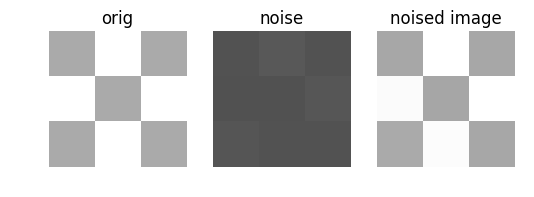

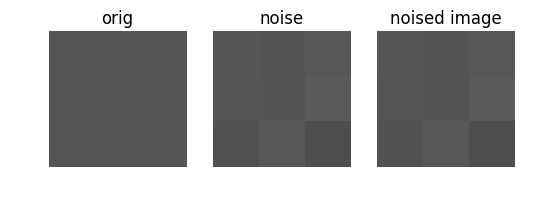

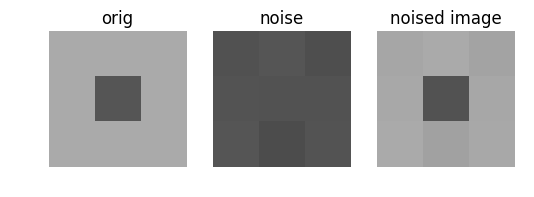

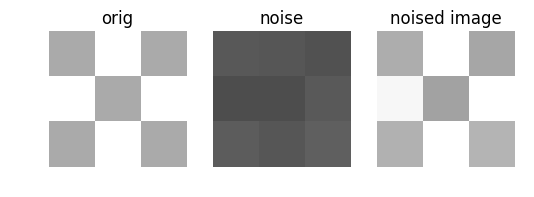

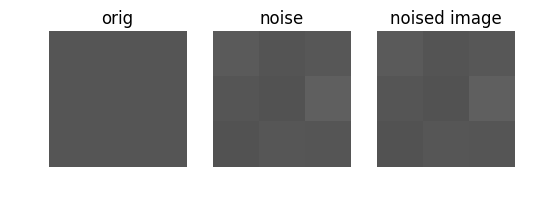

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import math


num_classes = 2
image_size = 3
N = 10
num_samples_to_print = 5
sigma_X = 0.05

class_descriptions = [
    {
        'sprite': [
            [0,1,0],
            [1,1,1],
            [0,1,0]
        ],
        'sprite_x': 0,
        'sprite_y': 0
    },
    {
        'sprite': [
            [1,1,1],
            [1,0,1],
            [1,1,1]
        ],
        'sprite_x': 0,
        'sprite_y': 0
    },
    {
        'sprite': [
            [1,0,0],
            [1,1,0],
            [1,1,1]
        ],
        'sprite_x': 0,
        'sprite_y': 3
    },
    {
        'sprite': [
            [1,1,1],
            [0,1,0],
            [0,1,0]
        ],
        'sprite_x': 3,
        'sprite_y': 3
    }
]

def class_descriptions_to_class_pics():
    class_pics = []
    for i, desc in enumerate(class_descriptions):
        if i >= num_classes:
            break
        pic = np.zeros((image_size, image_size), dtype=np.float32)
        for dx in range(3):
            for dy in range(3):
                if desc['sprite'][dy][dx] == 1:
                    pic[desc['sprite_y'] + dy, desc['sprite_x'] + dx] = 1.0
        class_pics.append(pic)
    return class_pics

class_pics = class_descriptions_to_class_pics()
# print(class_pics)

def print_images(titles, images):
    plt.figure(1)
    num_figures = len(images)
    for i, image in enumerate(images):
        image_size = image.shape[0]
        image_min = np.min(image)
        image_max = np.max(image)
        image_min = -1
        image_max = 2
        image_range = image_max - image_min
        image = np.maximum(image_min, image)
        image = np.minimum(image_max, image)
        image = (image - image_min) / image_range
        image_rgb = np.zeros((image_size, image_size, 3), dtype=np.float32)
        image_rgb[:,:,0] = image
        image_rgb[:,:,1] = image
        image_rgb[:,:,2] = image
        plt.subplot(1, num_figures, i + 1)
        plt.imshow(image_rgb, interpolation='nearest')
        plt.axis('off')
        plt.title(titles[i])
    plt.show()

def draw_samples(N, class_pics):
    samples = []
    samples_to_print = set(np.random.choice(N, (num_samples_to_print,), replace=False))
    for n in range(N):
        image = np.zeros((image_size, image_size), dtype=np.float32)
        features = np.random.choice(2, size=(num_classes,))
#         print(features)
        for k, v in enumerate(features):
            if v == 1:
                image += class_pics[k]
        image_orig = np.copy(image)
#         print_image(image)

        noise = np.random.randn(image_size, image_size).astype(np.float32) * sigma_X
#         print_image(noise)

        image += noise
        if n in samples_to_print:
#             print(n)
            print_images(['orig', 'noise', 'noised image'], [image_orig, noise, image])

        samples.append(image)
    return samples

samples = draw_samples(N, class_pics)


In [9]:
Z_columns = []
column = np.random.choice(2, (N,))
Z_columns.append(column)
K_plus = len(Z_columns)
# print(Z_columns)
M = []
M.append(np.sum(Z_columns[0]))
# print('M', M)

sigma_A = 0.5
sigma_X = 1.7
alpha = 1.0

for it in range(10):
    for n in range(N):
        k = 0
        while k < len(Z_columns):
            column = Z_columns[k]
            m = M[k]
            if m == 1 and column[n] == 1:
                # means that m_{-i} is zero
                # so, delete the column
                del Z_columns[k]
                del M[k]
                k -= 1
            else:
                # M_{-i} > 0
                # what do we do now???
                pass

            k += 1

# note that this code block wont do anything useful :-)  I abandoned it.
# A new one, based on this, is much lower down this page.

## Interlude: accelerated gibbs sampling

At this point, I looked at the tutorial's equation 22.  But there's a proportional-to sign, $\propto$.  How to handle this?  Since I'm not trying to do this research from scratch, just reproduce/understand the existing research, I reached out to Mr Google, to look for more explanations.  I found the following video, from Finale Doshi-Velez, which I'm going to interlude out to now.  The interlude is at: [accelerated_gibbs_samplings.ipynb](accelerated_gibbs_sampling.ipynb).


## Demonstration on 6x6 images, revisited

### Challenge: sampling from non-normalized distribution?

From reaching out to Doshi-Velez's presentation, it looks like we can sample a distribution that is only provided in proportionality, as long as it has a shape, which is well-defined, that we know how to sample from, ie typically a Gaussian.  There are probably other ways of handling other distributions, but a Gaussian should be reasonably straightforward to sample from, if we can get the distribution in that form.  Let's reach right back to the first section, and see what distribution(s) we need to sample from.

Equation 22 from the Griffiths and Ghahramani tutorial states:

$$
P(z_{ik} \mid \mathbf{X}, \mathbf{Z}_{-(i,k)}, \sigma_X, \sigma_A)
\propto
p(\mathbf{X} \mid \mathbf{Z}, \sigma_X, \sigma_A)
\,
P(z_{ik} \mid \mathbf{z}_{-i,k})
$$

The first term of this equation, ie the likelihood of $\mathbf{X}$, given the latent variables, and the hyper-parameters, is a Gaussian.  For the finite model, $P(z_{ik} \mid \mathbf{Z}_{-i,k})$ is given by equation 17 in the tutorial:

$$
P(z_{ik} = 1 \mid \mathbf{z}_{-i,k})
= \frac{m_{-i,k} + \frac{\alpha}{K}}
  {N + \frac{\alpha}{K}}
$$

This seems not to be a Gaussian.  How to sample from the product of a Gaussian and this term?

### Interlude: is the product of two normalized distributions also normalized?

Brainstorming a bit, we could sample from the Gaussian, which we could normalize first, and then multiply by $p(z_{ik} = 1 \mid \mathbf{z}_{-i,k})$.  Is it fair to say that the product of two normalized probability functions will be normalized?  Probably not, eg we could have the following two distributions:

$$
f(x) = 1
\mathrm{\,when\,} x \ge 0 \mathrm{\,and\,} x \le 1 \\ 
= 0 \mathrm{\, otherwise}
$$

(which integrates to 1), and:

$$
g(x) = 1
\mathrm{\,when\,} x \ge 2 \mathrm{\,and\,} x \le 3 \\ 
= 0 \mathrm{\, otherwise}
$$

... which integrates to 1 too.  But their product integrates to 0.

### Integrate the un-normalized distribution over $z_{ik}$?

Actually, the equation for the probaiblty of $z_{ik} = 1$ is not actually a probability distribution: it's the value of this probaiblity for one specific value of $z_{ik}$, ie $1$.

Let's try integrating over $c \cdot p(\mathbf{X} \mid \mathbf{Z}, \sigma_X, \sigma_A) \cdot P(z_{ik} \mid \mathbf{z}_{-i,k})$ $z_{ik}$, using a probability distribution of $z_{ik}$, rather than just one specific value, and where $c$ is a constant of normalization, that will make the integrant integrate to $1$.

$$
\int
c
\cdot
P(\mathbf{X} \mid \mathbf{Z}, \sigma_X, \sigma_A)
\cdot
P(z_{ik})
\,
dz_{ik}
$$

And since $z_{ik}$ is discrete, ie $z_{ik} \in \{0, 1\}$, then we can rewrite the integral as a sum:

$$
=
c
\sum_{z_{ik}=0}^1
\left(
    P(\mathbf{X} \mid \mathbf{Z}, \sigma_X, \sigma_A)
    \cdot
    P(z_{ik})
\right)
$$
&nbsp;

$$
=
c
\sum_{z_{ik}=0}^1
\left(
    \mathcal{N}(\mathbf{X}; \mu_{\mathbf{Z}, \sigma_A, \sigma_X}, \Sigma_{\mathbf{Z}, \sigma_A, \sigma_X})
    \cdot
    P(z_{ik})
\right)
$$



So, it seems like maybe we can simply calculate the value of the gaussian, for $z_{ik} \in \{0, 1\}$, and multiply by $P(z_{ik} \mid \mathbf{z}_{-i,k})$, each time; and then normalize the sum of these two products?  Just to imagine this a bit, let's say we have:

In [6]:
import numpy as np

p_X_given_Z = [0.03, 0.02]  # pretend Gaussian samples, not normalized
p_zik_given_Z_minus = [0.8, 0.2]  # normalized, sum to 1.0

#Then
p_zik_given_X_Z = [0] * 2
for zik in [0, 1]:
    p_zik_given_X_Z[zik] = p_X_given_Z[zik] * p_zik_given_Z_minus[zik]

print(p_zik_given_X_Z)

# normalize
p_zik_given_X_Z /= np.sum(p_zik_given_X_Z)
print('normalized p_zik_given_X_Z', p_zik_given_X_Z)


[0.024, 0.004]
normalized p_zik_given_X_Z [ 0.85714286  0.14285714]


So, the normalized values, with this toy data, are influenced by both the likelihood, and by the prior.

Let's run with this.

In [22]:
import random

Z_columns = []
column = np.random.choice(2, (N,))
Z_columns.append(column)
K_plus = len(Z_columns)
# print(Z_columns)
M = []
M.append(np.sum(Z_columns[0]))
# print('M', M)

sigma_A = 0.5
sigma_X = 1.7
alpha = 1.0


def columns_to_array(columns):
    rows = columns[0].shape[0]
    cols = len(columns)
    array = np.zeros((rows, cols), dtype=np.float32)
    for col, column in enumerate(columns):
        array[:, col] = column
    return array


def calc_p_X_given_Z(Z_columns, X, sigma_X, sigma_A):
    Z = columns_to_array(Z_columns)
    ZTZI = Z.T.dot(Z) + (sigma_X * sigma_X / sigma_A / sigma_A)
    ZTZIInv = np.linalg.inv(ZTZI)
    IZZZIZ = - Z.dot(ZTZIInv).dot(Z.T) + 1
    XT___X = X.T.dot(IZZZIZ).dot(X)
    trace_term = np.trace(XT___X)
    exponent = - 1 / (sigma_X * sigma_X) * trace_term
    gaussian_unnorm = np.exp(exponent)
    return gaussian_unnorm


def samples_to_X(samples):
    N = len(samples)
    X_features = samples[0].shape[0] * samples[0].shape[1]
    X = np.zeros((N, X_features), dtype=np.float32)
    for n, sample in enumerate(samples):
        X[n] = sample.reshape(X_features)
    return X


X = samples_to_X(samples)
print('X.shape', X.shape)
for it in range(10):
    num_added = 0
    num_removed = 0
    for n in range(N):
        k = 0
        while k < len(Z_columns):
            old_zik = Z_columns[k][n]
            if old_zik == 1:
                m_minusi_k = M[k] - 1
            else:
                m_minusi_k = M[k]
            if m_minusi_k > 0:
                # get the probabilty of z_ik given Z_minus_ik, for
                # zik = 0 and zik = 1
                p_zik_given_Zminus = np.zeros((2,), dtype=np.float32)
                p_zik_given_Zminus[1] = m_minusi_k / N
                p_zik_given_Zminus[0] = 1.0 - p_zik_given_Zminus[1]
                
                # and we need also to get the probability from the gaussian, again
                # for zik=0 and zik=1
                # for now, lets just stupidly calculate it, not do rank-1s or anything

                p_X_given_Z = np.zeros((2,), dtype=np.float32)
                for zik in [0, 1]:
                    Z_columns[k][n] = zik
                    # add epsilon to it, to avoid nans
                    p_X_given_Z[zik] = calc_p_X_given_Z(Z_columns, X, sigma_X, sigma_A) + 1e-9
                
                print('p_zik_given_Zminus', p_zik_given_Zminus)
                print('p_X_given_Z', p_X_given_Z)
                p_zik_given_X_Z_unnorm = np.multiply(
                    p_zik_given_Zminus, p_X_given_Z)
                p_zik_given_X_Z = p_zik_given_X_Z_unnorm / np.sum(p_zik_given_X_Z_unnorm)
                print('p_zik_given_X_Z', p_zik_given_X_Z)

                prob_zik_one = p_zik_given_X_Z[1]
                
                p = random.uniform(0, 1)
                if p <= prob_zik_one:
                    new_zik = 1
                else:
                    new_zik = 0
                if new_zik == 1 and old_zik == 0:
                    M[k] += 1
                    Z_columns[k][n] = new_zik
                elif new_zik == 0 and old_zik == 1:
                    M[k] -= 1
                    Z_columns[k][n] = new_zik
            else:
                del M[k]
                del Z_columns[k]
                num_removed += 1
                k -= 1

            k += 1
    print(Z_columns)

X.shape (10, 9)
p_zik_given_Zminus [ 0.60000002  0.40000001]
p_X_given_Z [  9.99999972e-10   9.99999972e-10]
p_zik_given_X_Z [ 0.60000002  0.40000001]
p_zik_given_Zminus [ 0.60000002  0.40000001]
p_X_given_Z [  9.99999972e-10   9.99999972e-10]
p_zik_given_X_Z [ 0.60000002  0.40000001]
p_zik_given_Zminus [ 0.60000002  0.40000001]
p_X_given_Z [  9.99999972e-10   9.99999972e-10]
p_zik_given_X_Z [ 0.60000002  0.40000001]
p_zik_given_Zminus [ 0.60000002  0.40000001]
p_X_given_Z [  9.99999972e-10   9.99999972e-10]
p_zik_given_X_Z [ 0.60000002  0.40000001]
p_zik_given_Zminus [ 0.69999999  0.30000001]
p_X_given_Z [  9.99999972e-10   9.99999972e-10]
p_zik_given_X_Z [ 0.69999999  0.30000001]
p_zik_given_Zminus [ 0.69999999  0.30000001]
p_X_given_Z [  9.99999972e-10   9.99999972e-10]
p_zik_given_X_Z [ 0.69999999  0.30000001]
p_zik_given_Zminus [ 0.80000001  0.2       ]
p_X_given_Z [  9.99999972e-10   9.99999972e-10]
p_zik_given_X_Z [ 0.80000001  0.2       ]
p_zik_given_Zminus [ 0.89999998  0.1   